In [ ]:
%load_ext autoreload
%autoreload 2
# !export PATH=/opt/homebrew/bin:$PATH

In [2]:
# download metadata of COCO Dataset
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip

In [1]:
# import dependencies 
from ExplanationDatasets.COCO.coco import *

from CECE.wordnet import *
from CECE.graph import *
from CECE.refine import *

from utils import read_image_from_url
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure

## Define hyperparameters of the Algorithm 

In [12]:
# dataset hyperparameters
coco_metadata_path = "annotations/instances_train2014.json" # this file is in the downloaded files of wget and uzip

# contains the objects that the subset of coco want to contain
# for this example which is the same example of the paper we will define a subset of coco 
# with images which contains
# dining table ^ person ^ pizza        or 
# dining table ^ person ^ wine glass   or 
# bed ^ person                         or 
# ... 

dataset_objects =[["dining table", "person", "pizza"],
                 ["dining table", "person",  "wine glass"],
                 ["bed", "person"],
                 ["bed", "book"],
                 ["bed", "teddy bear"],
                 ["bed", "fork"],
                 ["bed", "spoon"],
                 ["bed", "wine glass"],
                 ["bed", "pizza"],
                 ["dining table", "bed"],
                 ["person", "refrigerator"],
                 ["sink", "microwave"],
                 ["sink", "refrigerator"]]

# classifier hyperparameters

# the user can set a .csv file with classifications for a custom classifier
# otherwise you can set this value to None in order to produce this file using a pretrained network
# from this paper: http://places.csail.mit.edu
classification_path = "predictions.csv" 
# if prediction csv != None then create a dictionary with image_id to [predicted class, prediction_score]
if classification_path:
    # load predicitons file 
    predictions = {}
    pred_csv = pd.read_csv(classification_path, header = None)
    for row in pred_csv.iterrows():
        predictions[row[1][0]] = [row[1][1], row[1][2]]
        
        
# Graph Hyperparameters
# if graph_filename path exists this graph will be loaded
# otherwise thw graph will be created and will be saved in this filename 
graph_filename = "coco-graph.npy"

# System Architecture:

<img src="System Arch.png">


<strong>Input</strong>: 
* A source or start image (or an image id from coco dataset)
* A Target Label

<strong>Output</strong>: 
* A target image from Explanation Dataset
* A set of conceptual edits

<h5>The system will answer in this question: What would have to change in start image in order to be classified in Target Label?</h5>


## Step 1: Load Dataset

In this step the coco subset will be created and the most spesific query of each instance in order for the algorithm to work. 

For this step thw user cannot define anything exept the coco metadata (json) file. 

In [13]:
# Step 1: Create an instance of COCO Dataset
coco = COCO(coco_metadata_path)
# and define a subset with the spesified objects 
coco.create_dataset(dataset_objects, predictions = predictions)
# and then we have to create for each image the most spesific query
queries = {}
for im_id in coco.coco:
    queries[im_id] = create_msq(coco, im_id, True)


# using also the tbox in order for every query to have the hierachy 
tbox = create_tbox_coco(queries,materialize=True) # materialize tbox
queries = {k: rewrite_query(queries[k],tbox) for k in queries} # add concepts of hierarcy in query most spesific query
# for example if an image (or a query) contains a cat then we will also add in this object mamal, living thing ....

print ("This is a sample of a most spesified query for an image: ")
print (queries[list(queries.keys())[0]].concepts)

Loading Coco Metadata


  0%|          | 0/604907 [00:00<?, ?it/s]

Loading spesified subset of COCO


  0%|          | 0/13 [00:00<?, ?it/s]

This is a sample of a most spesified query for an image: 
[{'chair', 'instrumentality.n.03', 'chair.n.01', 'seat.n.03', 'object.n.01', 'entity.n.01', 'furniture.n.01', 'physical_entity.n.01', 'artifact.n.01', 'whole.n.02', 'furnishing.n.02', 'furniture'}
 {'person.n.01', 'causal_agent.n.01', 'person', 'object.n.01', 'physical_entity.n.01', 'entity.n.01', 'organism.n.01', 'whole.n.02', 'living_thing.n.01'}
 {'person.n.01', 'causal_agent.n.01', 'person', 'object.n.01', 'physical_entity.n.01', 'entity.n.01', 'organism.n.01', 'whole.n.02', 'living_thing.n.01'}
 {'article.n.02', 'instrumentality.n.03', 'kitchen', 'spoon.n.01', 'ware.n.01', 'structure.n.01', 'spoon', 'object.n.01', 'physical_entity.n.01', 'room.n.01', 'entity.n.01', 'whole.n.02', 'tableware.n.01', 'kitchen.n.01', 'cutlery.n.02', 'artifact.n.01', 'container.n.01', 'area.n.05'}
 {'instrumentality.n.03', 'vessel.n.03', 'kitchen', 'structure.n.01', 'bowl.n.01', 'object.n.01', 'physical_entity.n.01', 'room.n.01', 'entity.n.01', '

## Step 2: Create or load the graph for the images

In [14]:
graph = Graph(queries) # create a graph instance where the adjacency matrix will be loaded
if not os.path.exists(graph_filename): # if adjacency filename not exists
    adj_array = graph.create_graph(queries, graph_filename) # create the array and save it
else:
    adj_array = graph.load_graph(graph_filename) # else load the array without create it

# in this step we can add significance in the graph
target_class = "pizzeria"  # define the target class so the significance to be calculated 
adj_array = graph.array_with_significance(coco, target_class)

  0%|          | 0/3375 [00:00<?, ?it/s]

## Step 3: Create Local Counterfactual for a sample

In [15]:
def get_candidates(target_class):
    I = []
    for im_id, c in coco.coco.items():
        c = c["pred_class"][0]
        if c == target_class:
            I.append (graph.id_to_node[im_id])
    return I


def explain_sample(matr, start_id, get_candidates, target_class, verbose = True):
  start_node = graph.id_to_node[start_id]
  costs, paths = find_all(matr, start_node) # run dijkstra from start node to all

  paths = [[p, c] for p, c in zip(paths, costs)] 
  paths = [[p, cost] for p, cost in paths if p[-1] in get_candidates(target_class)]
  paths.sort(key=lambda x: x[1])


  path, cost = paths[0]
  if verbose:
    print (f"Start Url: {coco.coco[start_id]['url']}")
    print (f"Found path with cost: {cost}")
    print (f"Target Url: {coco.coco[graph.node_to_id[path[-1]]]['url']}, target_id: {graph.node_to_id[path[-1]]}")
    print (f"Target Label: {coco.coco[graph.node_to_id[path[-1]]]['pred_class']}")
    print_sequence(path, verbose)
  return paths[:10]


def print_sequence(path, verbose = True):
  figure(figsize=(15, 5 * len(path)), dpi=80)
  for i, n in enumerate(path):
    im_id = graph.node_to_id[n]
    url = coco.coco[im_id]["url"]
    im = read_image_from_url(url)

    plt.subplot(1, len(path), i + 1)
    plt.imshow(im)
    plt.title((f"Target Label: {coco.coco[im_id]['pred_class']}"))

  if verbose:
    refine (queries, graph.node_to_id[path[0]], graph.node_to_id[path[-1]], verbose)

Class of original image: restaurant
Target class: pizzeria
Start Url: http://farm2.staticflickr.com/1213/5177477436_756f3212b8_z.jpg
Found path with cost: 100.0
Target Url: http://farm3.staticflickr.com/2596/3702633725_cc2c8a188d_z.jpg, target_id: 351380
Target Label: ['pizzeria', 0.9145168662071228]
Remains the same: {'abstraction.n.06', 'dining table', 'eating.n.01', 'entity.n.01', 'whole.n.02', 'furniture', 'arrangement.n.02', 'organic_process.n.01', 'physical_entity.n.01', 'furnishing.n.02', 'instrumentality.n.03', 'table.n.01', 'group.n.01', 'object.n.01', 'consumption.n.01', 'bodily_process.n.01', 'process.n.06', 'dining.n.01', 'array.n.01', 'furniture.n.01', 'artifact.n.01'}
Remains the same: {'person.n.01', 'causal_agent.n.01', 'person', 'object.n.01', 'physical_entity.n.01', 'entity.n.01', 'organism.n.01', 'whole.n.02', 'living_thing.n.01'}
Remains the same: {'chair', 'instrumentality.n.03', 'chair.n.01', 'seat.n.03', 'object.n.01', 'entity.n.01', 'furniture.n.01', 'physical_e

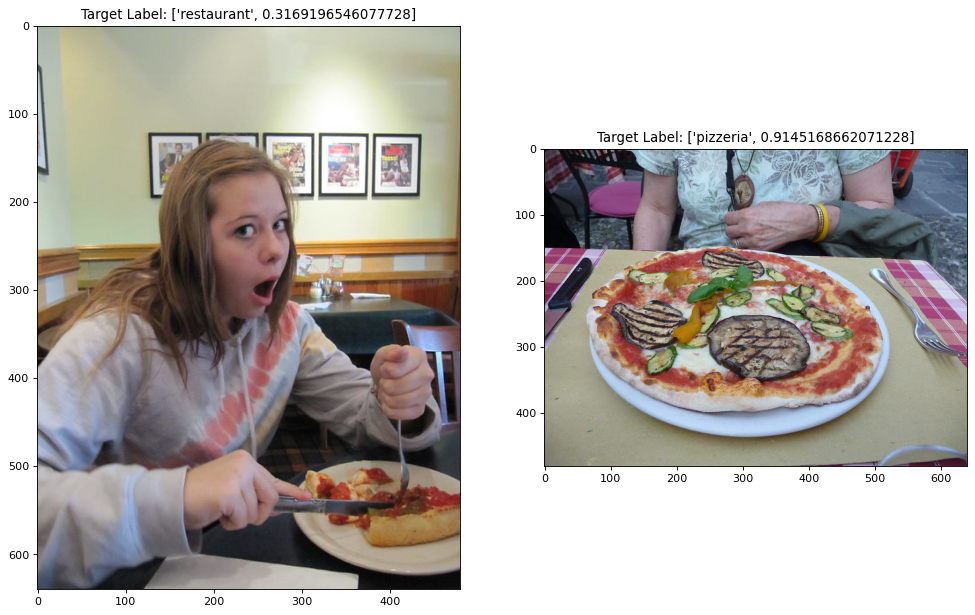

In [17]:
# provide a coco id as the start image
# for this image our algorithm will provide a target image which belongs in the target class 
# and a set of conceptual edits 
start_id =  579042 # 377339 #276491
original_class = coco.coco[start_id]["pred_class"][0]
print (f"Class of original image: {original_class}")
print (f"Target class: {target_class}")

paths = explain_sample(adj_array, start_id, get_candidates, target_class, verbose = True)

## Global Counterfactuals 

In [21]:
image_objects = ["person", "pizza"] # objects in images which describes the region for example here we select images 
# that we want to contains a person and a pizza and we set the target class as bedroom
# So we want to find the edits from images with person and pizza in order to be classified as a bedroom
target_class = "bedroom"

keys = []
for im_id in coco.coco.keys():
  labels = coco.coco[im_id]["label_texts"]
  labels = rewrite_query(Query(np.array([labels])), tbox).concepts[0]
  if set(image_objects).issubset(labels): #image_to_class[im_id][0][0] == source_class:
      keys.append(im_id)
print (f"Found: {len(keys)} images with: {' ^ '.join(image_objects)}")

Found: 617 images with: person ^ pizza


In [23]:
#calculate weights counting significance
matr = graph.array_with_significance(coco, target_class)
# calculate path of each image of dataset to other class 
paths = {}
for start_id in tqdm(keys):
  if start_id in paths:
    continue
  target_node = explain_sample(matr, start_id, get_candidates, target_class, verbose = False)[0][0][-1]
  target_id = graph.node_to_id[target_node]
  paths[start_id] = target_id

  0%|          | 0/3375 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
added_concepts = {}
removed_concepts = {}

msq = queries

for start_id, target_id in paths.items():
  source_labels = msq[start_id].concepts[0]
  target_labels = msq[target_id].concepts[0]

  added = set (target_labels) - set (source_labels)
  for c in added:
    if c not in added_concepts:
      added_concepts[c] = 1
    else:
      added_concepts[c] += 1


  removed = set (source_labels) - set (target_labels) 
  for c in removed:
    if c not in removed_concepts:
      removed_concepts[c] = 1
    else:
      removed_concepts[c] += 1

global_concepts = {}
for ac, n in added_concepts.items():
  if ac in removed_concepts:
    n = n - removed_concepts[ac]
  global_concepts[ac] = n


for ac, n in removed_concepts.items():
  if ac in added_concepts:
    n = n - added_concepts[ac]
  global_concepts[ac] =  -n

added_concepts = [[k, v/len(paths)] for k, v in sorted(global_concepts.items(), key=lambda item: item[1], reverse = True) if v > 0][:15]
removed_concepts = [[k, v/len(paths)] for k, v in sorted(global_concepts.items(), key=lambda item: item[1], reverse = False) if v < 0][:15]

global_concepts = []
for c, v in added_concepts:
  global_concepts.append([c, v])
for c, v in removed_concepts:
  global_concepts.append([c, v])

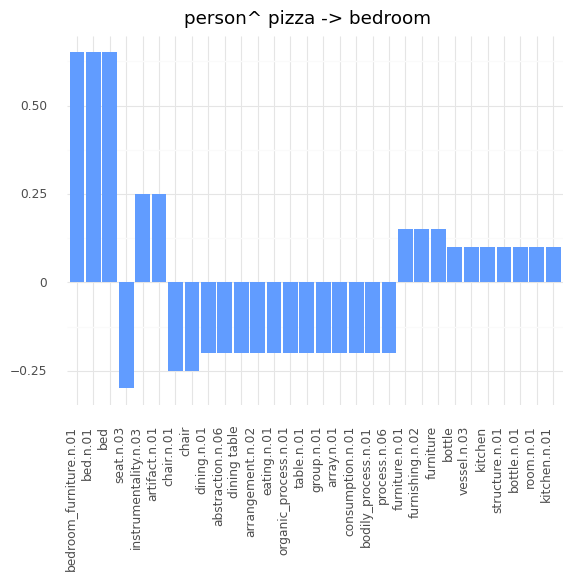

<ggplot: (8784426733114)>

In [25]:
from plotnine import *
import pandas as pd

global_concepts = sorted(global_concepts, key=lambda item: abs(item[1]), reverse= True)

df = pd.DataFrame({"Objects":[a[0] for a in global_concepts], "y": [a[1] for a in global_concepts]})
(ggplot(aes(x="Objects", weight="y",), df) +
 geom_bar(fill="#619CFF") + 
 ylab("") + xlab("") + 
 scale_x_discrete(limits=df['Objects'].tolist()) +
 theme_minimal() +
 theme(axis_text_x=element_text(rotation=90, hjust=1))+
 labs(title= f"{'^ '.join(image_objects)} -> {target_class}" )
)